<a href="https://colab.research.google.com/github/tontantip/DADS7202-Deep_learning/blob/main/week3/MLP2_ex1_1_StaticViz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install torchinfo

In [ ]:
import sys
print( f"Python {sys.version}\n" )

import random
import time

import sklearn as sk
print( f"Scikit-Learn {sk.__version__}" )

import pandas as pd
print( f"Pandas {pd.__version__}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import torchinfo
print( f"torchinfo {torchinfo.__version__}" )
import torch
print( f"PyTorch {torch.__version__}" )

# Get all available accelerators such as CUDA, MPS, MTIA, or XPU
num_accelerators = torch.accelerator.device_count()

if (num_accelerators <= 0):
    print("|- No hardware accelerators found. Using CPU only.")
else:
    print(f"|- PyTorch detected {num_accelerators} hardware accelerator(s)")
    print(f"|- PyTorch detected '{torch.accelerator.current_accelerator().type.upper()}' as the current accelerator")

    # Check cuda availability
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"|- PyTorch detected {num_gpus} CUDA GPU(s):")
    for i in range(num_gpus):
        print(f"   |- CUDA GPU {i}: {torch.cuda.get_device_name(i)}")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

Scikit-Learn 1.6.1
Pandas 2.2.2

NumPy 2.0.2

torchinfo 1.8.0
PyTorch 2.9.0+cpu
|- No hardware accelerators found. Using CPU only.


In [ ]:
# Reproducibility & Device Configuration
def set_seeds(seed=42):
    """Sets fixed seeds for reproducibility across all libraries."""
    random.seed(seed)     # Controls Python's built-in random numbers.
    np.random.seed(seed)  # Controls NumPy's random arrays.
    torch.manual_seed(seed)           # Controls CPU weight initialization.
    torch.cuda.manual_seed_all(seed)  # Controls GPU weight initialization.

    # Ensure deterministic behavior for some PyTorch operations
    torch.backends.cudnn.deterministic = True # Ensure the GPU doesn't use "fast but slightly random" algorithms for math
    torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed} for reproducibility.")

set_seeds(42)

Seeds set to 42 for reproducibility.


In [ ]:
# Detect GPU (CUDA), Apple Silicon (MPS), or fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 2. Prepare the dataset

Load the dataset:

In [ ]:
# Get the dataset from Keras (ready-to-use format)
from keras.datasets import boston_housing
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

# Split the validation set
# Complete the data splitting BEFORE normalization to prevent data leakage
x_val, x_test, y_val, y_test = sk.model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f"{x_train.shape=}, {y_train.shape=}")
print(f"{x_val.shape=}, {y_val.shape=}")
print(f"{x_test.shape=}, {y_test.shape=}")

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train.shape=(404, 13), y_train.shape=(404,)
x_val.shape=(51, 13), y_val.shape=(51,)
x_test.shape=(51, 13), y_test.shape=(51,)


Preview the dataset:

In [ ]:
def boston_dataframe(x, y):
    df = pd.DataFrame(x, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT' ] )
    df['MEDV'] = pd.Series(y)
    return df

print('===== PREVIEW: THE TRAIN SET =====')
display( boston_dataframe(x_train,y_train).describe().style.format(precision=2) )
print('\n===== PREVIEW: THE VAL SET =====')
display( boston_dataframe(x_val,y_val).describe().style.format(precision=2) )
print('\n===== PREVIEW: THE TEST SET =====')
display( boston_dataframe(x_test,y_test).describe().style.format(precision=2) )

===== PREVIEW: THE TRAIN SET =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,3.75,11.48,11.10,0.06,0.56,6.27,69.01,3.74,9.44,405.90,18.48,354.78,12.74,22.40
std,9.24,23.77,6.81,0.24,0.12,0.71,27.94,2.03,8.70,166.37,2.20,94.11,7.25,9.21
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,188.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.13,0.00,0.45,5.87,45.48,2.08,4.00,279.00,17.23,374.67,6.89,16.68
50%,0.27,0.00,9.69,0.00,0.54,6.20,78.50,3.14,5.00,330.00,19.10,391.25,11.39,20.75
75%,3.67,12.50,18.10,0.00,0.63,6.61,94.10,5.12,24.00,666.00,20.20,396.16,17.09,24.80
max,88.98,100.00,27.74,1.00,0.87,8.72,100.00,10.71,24.00,711.00,22.00,396.90,37.97,50.00



===== PREVIEW: THE VAL SET =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,3.05,12.55,11.26,0.12,0.55,6.44,66.71,3.89,9.69,408.51,17.85,373.23,11.49,24.68
std,5.43,20.84,7.20,0.33,0.12,0.72,28.61,2.29,8.58,172.58,2.28,58.64,6.07,10.32
min,0.01,0.00,1.22,0.00,0.39,5.04,6.80,1.53,1.00,188.00,13.00,24.65,1.92,5.60
25%,0.08,0.00,5.06,0.00,0.45,5.96,43.90,2.09,4.50,274.50,16.25,378.22,7.13,19.40
50%,0.21,0.00,9.69,0.00,0.55,6.34,70.20,2.89,5.00,330.00,18.00,391.98,10.29,21.70
75%,3.29,21.00,18.10,0.00,0.61,6.85,92.75,5.23,16.00,666.00,20.20,396.90,14.89,29.70
max,25.05,90.00,27.74,1.00,0.87,8.30,100.00,9.22,24.00,711.00,21.00,396.90,26.77,50.00



===== PREVIEW: THE TEST SET =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,3.13,9.25,11.27,0.08,0.53,6.27,66.98,4.14,10.27,426.49,18.90,355.10,13.12,21.48
std,5.37,22.37,7.04,0.27,0.10,0.62,29.74,2.48,9.04,183.34,1.59,95.10,7.23,7.62
min,0.02,0.00,1.38,0.00,0.39,4.88,6.00,1.47,1.00,187.00,14.70,27.25,3.92,7.00
25%,0.09,0.00,5.91,0.00,0.45,6.05,39.90,2.33,4.00,290.00,17.85,377.53,7.53,17.20
50%,0.25,0.00,9.90,0.00,0.52,6.18,75.00,3.38,5.00,330.00,19.20,392.30,11.41,22.20
75%,3.80,0.00,18.10,0.00,0.59,6.46,94.95,5.27,24.00,666.00,20.20,395.93,18.30,24.75
max,22.60,90.00,27.74,1.00,0.77,8.78,100.00,12.13,24.00,711.00,21.20,396.90,31.99,46.70


Normalize each feature (in X) separately:


In [ ]:
# Compute means and SDs from *the train set*
# 'axis' = Axis or axes along which the means are computed. The default is to compute the mean of the flattened array.
mean = x_train.mean(axis=0)
sd = x_train.std(axis=0)
print(f"{mean.shape=} , {sd.shape=}\n")

# Normalize 13 features
x_train_norm = ( x_train - mean ) / sd
x_val_norm = ( x_val - mean ) / sd
x_test_norm = ( x_test - mean ) / sd

# Inspect
print('===== PREVIEW: THE TRAIN SET (AFTER NORM) =====')
display( boston_dataframe(x_train_norm,y_train).describe().style.format(precision=2) )
print('\n===== PREVIEW: THE VAL SET (AFTER NORM) =====')
display( boston_dataframe(x_val_norm,y_val).describe().style.format(precision=2) )
print('\n===== PREVIEW: THE TEST SET (AFTER NORM) =====')
display( boston_dataframe(x_test_norm,y_test).describe().style.format(precision=2) )

mean.shape=(13,) , sd.shape=(13,)

===== PREVIEW: THE TRAIN SET (AFTER NORM) =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,22.40
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,9.21
min,-0.41,-0.48,-1.56,-0.26,-1.47,-3.82,-2.37,-1.29,-0.97,-1.31,-2.67,-3.77,-1.52,5.00
25%,-0.40,-0.48,-0.88,-0.26,-0.89,-0.55,-0.84,-0.82,-0.63,-0.76,-0.57,0.21,-0.81,16.68
50%,-0.38,-0.48,-0.21,-0.26,-0.17,-0.10,0.34,-0.29,-0.51,-0.46,0.28,0.39,-0.19,20.75
75%,-0.01,0.04,1.03,-0.26,0.63,0.48,0.90,0.68,1.68,1.57,0.78,0.44,0.60,24.80
max,9.23,3.73,2.45,3.89,2.68,3.47,1.11,3.44,1.68,1.84,1.60,0.45,3.48,50.00



===== PREVIEW: THE VAL SET (AFTER NORM) =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,-0.08,0.05,0.02,0.23,-0.03,0.24,-0.08,0.07,0.03,0.02,-0.29,0.20,-0.17,24.68
std,0.59,0.88,1.06,1.35,1.01,1.01,1.03,1.13,0.99,1.04,1.04,0.62,0.84,10.32
min,-0.40,-0.48,-1.45,-0.26,-1.41,-1.74,-2.23,-1.09,-0.97,-1.31,-2.49,-3.51,-1.49,5.60
25%,-0.40,-0.48,-0.89,-0.26,-0.95,-0.44,-0.90,-0.81,-0.57,-0.79,-1.01,0.25,-0.77,19.40
50%,-0.38,-0.48,-0.21,-0.26,-0.09,0.11,0.04,-0.42,-0.51,-0.46,-0.22,0.40,-0.34,21.70
75%,-0.05,0.40,1.03,-0.26,0.48,0.82,0.85,0.73,0.76,1.57,0.78,0.45,0.30,29.70
max,2.31,3.31,2.45,3.89,2.68,2.86,1.11,2.70,1.68,1.84,1.15,0.45,1.94,50.00



===== PREVIEW: THE TEST SET (AFTER NORM) =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,-0.07,-0.09,0.02,0.07,-0.20,0.01,-0.07,0.20,0.10,0.12,0.19,0.00,0.05,21.48
std,0.58,0.94,1.03,1.13,0.86,0.88,1.07,1.22,1.04,1.10,0.72,1.01,1.00,7.62
min,-0.40,-0.48,-1.43,-0.26,-1.41,-1.96,-2.26,-1.12,-0.97,-1.32,-1.72,-3.48,-1.22,7.00
25%,-0.40,-0.48,-0.76,-0.26,-0.96,-0.30,-1.04,-0.69,-0.63,-0.70,-0.28,0.24,-0.72,17.20
50%,-0.38,-0.48,-0.18,-0.26,-0.28,-0.12,0.21,-0.18,-0.51,-0.46,0.33,0.40,-0.18,22.20
75%,0.01,-0.48,1.03,-0.26,0.29,0.27,0.93,0.75,1.68,1.57,0.78,0.44,0.77,24.75
max,2.04,3.31,2.45,3.89,1.82,3.54,1.11,4.14,1.68,1.84,1.24,0.45,2.66,46.70


Convert to PyTorch tensors, reshape, and create Tensor datasets:

In [ ]:
X_train = torch.tensor(x_train_norm, dtype=torch.float32)
X_val = torch.tensor(x_val_norm, dtype=torch.float32)
X_test = torch.tensor(x_test_norm, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
Y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
Y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_val.shape=}, {Y_val.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
val_ds = torch.utils.data.TensorDataset(X_val, Y_val)
test_ds = torch.utils.data.TensorDataset(X_test, Y_test)

X_train.shape=torch.Size([404, 13]), Y_train.shape=torch.Size([404, 1])
X_val.shape=torch.Size([51, 13]), Y_val.shape=torch.Size([51, 1])
X_test.shape=torch.Size([51, 13]), Y_test.shape=torch.Size([51, 1])


# 3. Create the network architecture

In [ ]:
class BostonModel(torch.nn.Module):
    def __init__(self, input_dim=13):
        super(BostonModel, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),

            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
model = BostonModel().to(device)
model

BostonModel(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
BostonModel                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       896
│    └─BatchNorm1d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       2,080
│    └─BatchNorm1d: 2-6                  64
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       33
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0

# 4. Train the model (train + val sets)

## 4.1 Preparation

Prepare two modes of model saving and loading:

In [ ]:
print("--- Model Export Menu ---")
print("1. Save Weight-Only")
print("2. Save Full-Checkpoint")
choice = input("Select an option (1-2): ").strip()

if (choice == '1'):
    save_weights_only = True
    best_model_path = 'best_weights.pt'
else:
    save_weights_only = False
    best_model_path = 'best_checkpoint.tar'

--- Model Export Menu ---
1. Save Weight-Only
2. Save Full-Checkpoint
Select an option (1-2): 2


In [ ]:
def save_model(model, optimizer, epoch, save_weights_only=save_weights_only, save_path=best_model_path):
    """
    Locally save the given model to disk

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer associated.
        epoch (int): The current epoch number (the first epoch is 1).
        save_weights_only (bool): If True, only the model's weights (.pt) will be saved.
            Otherwise, the full state dictionary (.tar) will be saved.
            Default is to use the global variable 'save_weights_only'.
        save_path (str): The local path to save the model file.
            Default is to use the global variable 'best_model_path'.
    """
    if save_weights_only:
        # Weights only: lightweight and portable
        torch.save(model.state_dict(), save_path)
        print(f"---- Epoch {epoch+1:03d}: Weights saved to '{save_path}'")
    else:
        # Full Checkpoint: includes all metadata to resume training
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        torch.save( checkpoint, save_path )
        print(f"---- Epoch {epoch+1:03d}: Full checkpoint saved to '{save_path}'")

In [ ]:
def load_model(save_path=best_model_path, model_instance=BostonModel()):
    """
    Loads a model regardless of whether it's a weight-only file or full checkpoint to the local disk.

    Args:
        save_path (str): The local path to the saved model file.
            Default is to use the global variable 'best_model_path'.
        model_instance (torch.nn.Module): An initialized instance of your model architecture.
            Default is to use the global variable 'BostonModel()'.

    Returns:
        torch.nn.Module: The loaded model instance that is set to eval mode.
    """
    loaded_obj = torch.load(save_path)

    if isinstance(loaded_obj, dict) and 'model_state_dict' in loaded_obj:
        # It's a full checkpoint
        model_instance.load_state_dict(loaded_obj['model_state_dict'])
    else:
        # It's a weight-only state_dict
        model_instance.load_state_dict(loaded_obj)

    return model_instance.eval()

Other training preparation:

In [ ]:
@torch.inference_mode()
def evaluate(model, loader, criterion_mse, criterion_mae):
    """
    Evaluates the model on a given dataset using MSE and MAE metrics.
    Use this function with validation and test sets.

    Args:
        model (torch.nn.Module): The PyTorch model to evaluate.
        loader (torch.utils.data.DataLoader): DataLoader containing the dataset to evaluate on.
        criterion_mse (torch.nn.Module): The Mean Squared Error loss function.
        criterion_mae (torch.nn.Module): The Mean Absolute Error loss function.

    Returns:
        tuple: A tuple containing two floats:
            - avg_mse: The average Mean Squared Error over the dataset.
            - avg_mae: The average Mean Absolute Error over the dataset.
    """
    model.eval()

    total_mse = 0
    total_mae = 0
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        preds = model(X)
        total_mse += criterion_mse(preds, Y).item() * X.shape[0]
        total_mae += criterion_mae(preds, Y).item() * X.shape[0]

    return total_mse / len(loader.dataset), total_mae / len(loader.dataset)


## 4.2 Train loop

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion_mse = torch.nn.MSELoss()  # Loss
criterion_mae = torch.nn.L1Loss()   # Evaluation metric

best_val_loss = float('inf')
epochs = 300

# Initialize history for future visualization
history = {
    'train_mse': [],
    'val_mse': [],
    'train_mae': [],
    'val_mae': []
}

for epoch in range(epochs):
    epoch_start = time.time()

    model.train()
    train_loss_mse = 0
    train_loss_mae = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()

        preds = model(X)
        loss_mse = criterion_mse(preds, Y)
        loss_mae = criterion_mae(preds, Y)

        loss_mse.backward()
        optimizer.step()

        train_loss_mse += loss_mse.item() * X.shape[0]
        train_loss_mae += loss_mae.item() * X.shape[0]

    val_mse, val_mae = evaluate(model, val_loader, criterion_mse, criterion_mae)
    epoch_duration = time.time() - epoch_start

    # Record metrics
    history['train_mse'].append(train_loss_mse / len(train_loader.dataset))
    history['train_mae'].append(train_loss_mae / len(train_loader.dataset))
    history['val_mse'].append(val_mse)
    history['val_mae'].append(val_mae)

    # Save best model logic based on minimum validation loss
    if val_mse < best_val_loss:
        best_val_loss = val_mse
        save_model(model, optimizer, epoch)

    # Print the summary of this epoch
    print(f"Epoch {epoch+1:03d} | Time: {epoch_duration:.4f}s | Train MSE: {history['train_mse'][-1]:.2f} | Train MAE: {history['train_mae'][-1]:.2f} | Val MSE: {val_mse:.2f} | Val MAE: {val_mae:.2f}")

---- Epoch 001: Full checkpoint saved to 'best_checkpoint.tar'
Epoch 001 | Time: 0.1859s | Train MSE: 579.43 | Train MAE: 22.30 | Val MSE: 700.88 | Val MAE: 24.49
---- Epoch 002: Full checkpoint saved to 'best_checkpoint.tar'
Epoch 002 | Time: 0.0351s | Train MSE: 564.35 | Train MAE: 22.08 | Val MSE: 675.03 | Val MAE: 24.12
---- Epoch 003: Full checkpoint saved to 'best_checkpoint.tar'
Epoch 003 | Time: 0.0322s | Train MSE: 550.93 | Train MAE: 21.87 | Val MSE: 648.78 | Val MAE: 23.74
---- Epoch 004: Full checkpoint saved to 'best_checkpoint.tar'
Epoch 004 | Time: 0.0308s | Train MSE: 536.67 | Train MAE: 21.65 | Val MSE: 627.22 | Val MAE: 23.43
---- Epoch 005: Full checkpoint saved to 'best_checkpoint.tar'
Epoch 005 | Time: 0.0342s | Train MSE: 522.84 | Train MAE: 21.41 | Val MSE: 609.87 | Val MAE: 23.16
---- Epoch 006: Full checkpoint saved to 'best_checkpoint.tar'
Epoch 006 | Time: 0.0355s | Train MSE: 509.73 | Train MAE: 21.19 | Val MSE: 589.07 | Val MAE: 22.83
---- Epoch 007: Full c

## 4.3 Visualization

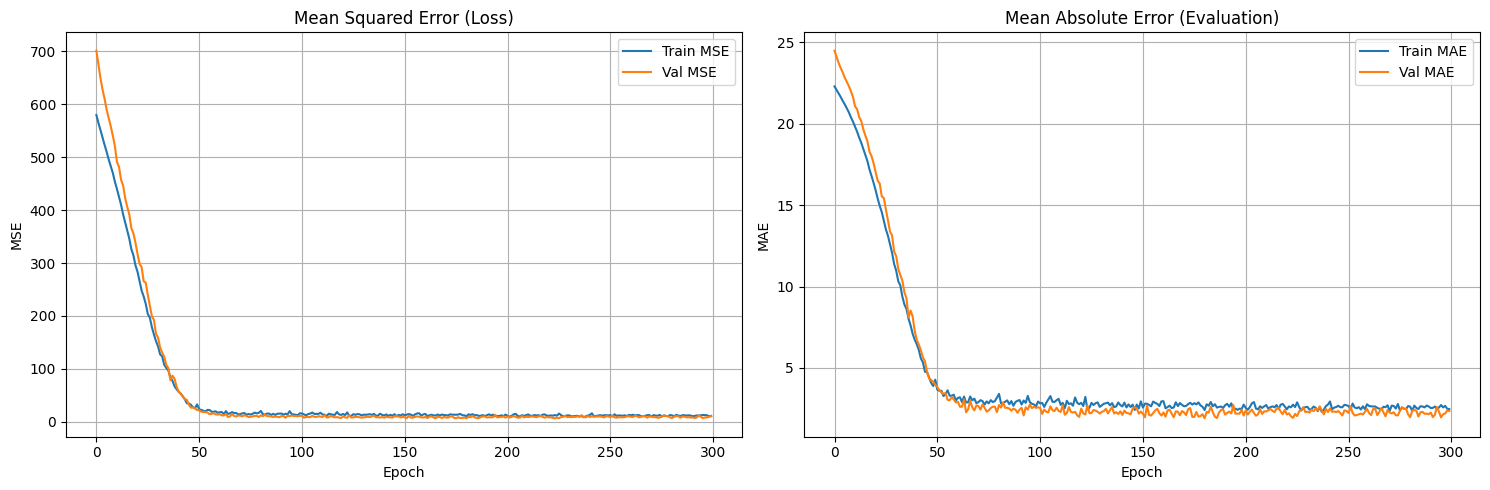

In [ ]:
"""Plots training and validation metrics side-by-side."""
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot MSE
ax1.plot(history['train_mse'], label='Train MSE')
ax1.plot(history['val_mse'], label='Val MSE')
ax1.set_title('Mean Squared Error (Loss)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.legend()
ax1.grid(True)

# Plot MAE
ax2.plot(history['train_mae'], label='Train MAE')
ax2.plot(history['val_mae'], label='Val MAE')
ax2.set_title('Mean Absolute Error (Evaluation)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# 5. Evaluate the model (test set)

In [ ]:
# Evaluate the last model
last_mse, last_mae = evaluate(model, test_loader, torch.nn.MSELoss(), torch.nn.L1Loss())

In [ ]:
# Load and evaluate the best model (saved during training)
best_model = load_model(best_model_path).to(device)
best_mse, best_mae = evaluate(best_model, test_loader, torch.nn.MSELoss(), torch.nn.L1Loss())

In [ ]:
print("\n" + "="*45)
print("SIDE-BY-SIDE EVALUATION ON TEST SET")
print(f"Device: {device}")
print("="*45)
print(f"{'Metric':<15} | {'Best Model':>12} | {'Last Model':>12}")
print(f"{'-'*15}-+-{'-'*12}-+-{'-'*12}")
print(f"{'MSE (Loss)':<15} | {best_mse:>12.4f} | {last_mse:>12.4f}")
print(f"{'MAE (Eval)':<15} | {best_mae:>12.4f} | {last_mae:>12.4f}")
print("="*45)


SIDE-BY-SIDE EVALUATION ON TEST SET
Device: cpu
Metric          |   Best Model |   Last Model
----------------+--------------+-------------
MSE (Loss)      |      20.8647 |      18.2857
MAE (Eval)      |       2.7602 |       2.8066


# 6. Inference

In [ ]:
# Inference Examples using the Best Model
print("\n--- Inference Examples (Best Model) ---")
X_test_batch, Y_test_batch = next(iter(test_loader))

# Single Sample
single_sample = X_test_batch[0].unsqueeze(0).to(device)
single_pred = best_model(single_sample)
print(f"\nSingle Sample Pred: {single_pred.item():.2f} | Actual: {Y_test_batch[0].item():.2f}")

# Batch (subset)
batch_samples = X_test_batch[:5].to(device)
batch_preds = best_model(batch_samples)
print(f"\nBatch Preds (first 5):\n{batch_preds.squeeze().tolist()}")
print(f"Actual Labels (first 5):\n{Y_test_batch[:5].squeeze().tolist()}")


--- Inference Examples (Best Model) ---

Single Sample Pred: 20.15 | Actual: 21.20

Batch Preds (first 5):
[20.151752471923828, 22.102855682373047, 13.593399047851562, 18.601823806762695, 13.799802780151367]
Actual Labels (first 5):
[21.200000762939453, 23.200000762939453, 27.5, 19.799999237060547, 14.100000381469727]
